In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras_contrib.layers import CRF
import itertools
plt.style.use("ggplot")

/Users/koontzj/Library/Python/3.7/lib/python/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/koontzj/Library/Python/3.7/lib/python/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/koontzj/Library/Python/3.7/lib/python/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/koontzj/Library/Python/3.7/lib/python/site-packages

#### AnatEM anatomical entity mention corpus 
http://nactem.ac.uk/anatomytagger/
#### Architecture
https://www.depends-on-the-definition.com/sequence-tagging-lstm-crf/ <br>
Modifications to architecture: Dropout layers added, Adam optimizer used 

In [2]:
tf.__version__

'1.14.0'

In [3]:
BATCH_SIZE = 32
EPOCHS = 10
MAX_LEN = 75
EMBEDDING = 20

In [4]:
PATH_TRAIN = 'data/AnatEM-1.0.2/conll/train/'
PATH_TEST = 'data/AnatEM-1.0.2/conll/test/'

In [5]:
import os
arr_train = os.listdir(PATH_TRAIN)
arr_test = os.listdir(PATH_TEST)

In [6]:
def process(arr, path):
    arr = list(filter(lambda x: x.find('caption') == -1, arr))
    arr = list(filter(lambda x: x.find('sec') == -1, arr))
    texts = []
    for el in arr:
        f = open(path+el, "rt")
        text = f.readlines()
        text = [el.strip('\n').split() for el in text]
        texts.append(text)
    out = list(itertools.chain.from_iterable(texts))
    return out

In [7]:
train_processed = process(arr_train, PATH_TRAIN)
test_processed = process(arr_test, PATH_TEST )

In [8]:
import pandas as pd
def to_df(arr):
    processed = []
    c = 1
    for i in range(len(arr)):
        if arr[i] == []:
            processed.append('EOS')
            c += 1
        else:
            processed.append((arr[i], 'Sentence: ' + str(c)))
    filtered = list(filter(lambda x: x != 'EOS', processed))
    filtered = [(x[0][0], x[0][1], x[1]) for x in filtered]
    df = pd.DataFrame(filtered, columns=['Word', 'Tag', 'Sentence#'])
    return df

In [9]:
df_train = to_df(train_processed)
df_test = to_df(test_processed)
df = pd.concat([df_train, df_test])

In [10]:
words = list(set(df["Word"].values))
words.append("ENDPAD")
n_words = len(words); n_words

13986

In [11]:
tags = list(set(df["Tag"].values))
n_tags = len(tags); n_tags


25

In [12]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence#").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [13]:
getter = SentenceGetter(df)

In [14]:
sentences = getter.sentences

In [15]:
df.head()

,Word,Tag,Sentence#
0,Obstructive,O,Sentence: 1
1,nephropathy,O,Sentence: 1
2,:,O,Sentence: 1
3,lessons,O,Sentence: 1
4,from,O,Sentence: 1


In [16]:
max_len = 75
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

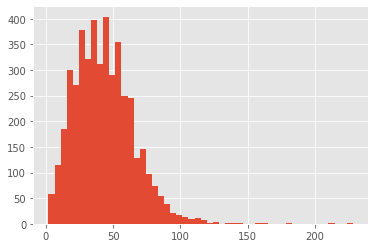

In [17]:
%matplotlib inline
plt.hist([len(sen) for sen in sentences], bins= 50)
plt.show()

In [18]:
tag2idx["O"]


8

In [19]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]


In [20]:
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=0)


In [21]:
y = [[tag2idx[w[1]] for w in s] for s in sentences]


In [22]:
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])


In [23]:
from keras.utils import to_categorical


In [24]:
y = [to_categorical(i, num_classes=n_tags) for i in y]


In [25]:
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)


In [26]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF

In [27]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words + 1, output_dim=20,
                  input_length=max_len, mask_zero=True)(input)  # 20-dim embedding
model = Dropout(0.5)(model)
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = Dropout(0.2)(model)
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags)  # CRF layer
out = crf(model)  # output





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [28]:
model = Model(input, out)

In [29]:
model.compile(optimizer="Adam", loss=crf.loss_function, metrics=[crf.accuracy])


/Users/koontzj/Library/Python/3.7/lib/python/site-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/Users/koontzj/Library/Python/3.7/lib/python/site-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


In [30]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 75, 20)            279740    
_________________________________________________________________
dropout_1 (Dropout)          (None, 75, 20)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 75, 100)           28400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 75, 100)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 75, 50)            5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 75, 25)            1950      
Total para

In [31]:
history = model.fit(X_tr, np.array(y_tr), batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_split=0.2, verbose=1)



Train on 3252 samples, validate on 813 samples
Epoch 1/10
3252/3252 [==============================] - 21s 6ms/step - loss: 6.9867 - crf_viterbi_accuracy: 0.7817 - val_loss: 5.1895 - val_crf_viterbi_accuracy: 0.9086
Epoch 2/10
3252/3252 [==============================] - 22s 7ms/step - loss: 6.3446 - crf_viterbi_accuracy: 0.9079 - val_loss: 5.0673 - val_crf_viterbi_accuracy: 0.9086
Epoch 3/10
3252/3252 [==============================] - 17s 5ms/step - loss: 6.1842 - crf_viterbi_accuracy: 0.9113 - val_loss: 4.9179 - val_crf_viterbi_accuracy: 0.9214
Epoch 4/10
3252/3252 [==============================] - 21s 6ms/step - loss: 6.0858 - crf_viterbi_accuracy: 0.9257 - val_loss: 4.8819 - val_crf_viterbi_accuracy: 0.9329
Epoch 5/10
3252/3252 [==============================] - 19s 6ms/step - loss: 6.0536 - crf_viterbi_accuracy: 0.9316 - val_loss: 4.8592 - val_crf_viterbi_accuracy: 0.9350
Epoch 6/10
3252/3252 [==============================] - 19s 6ms/step - loss: 6.0292 - crf_viterbi_accuracy:

In [32]:
hist = pd.DataFrame(history.history)

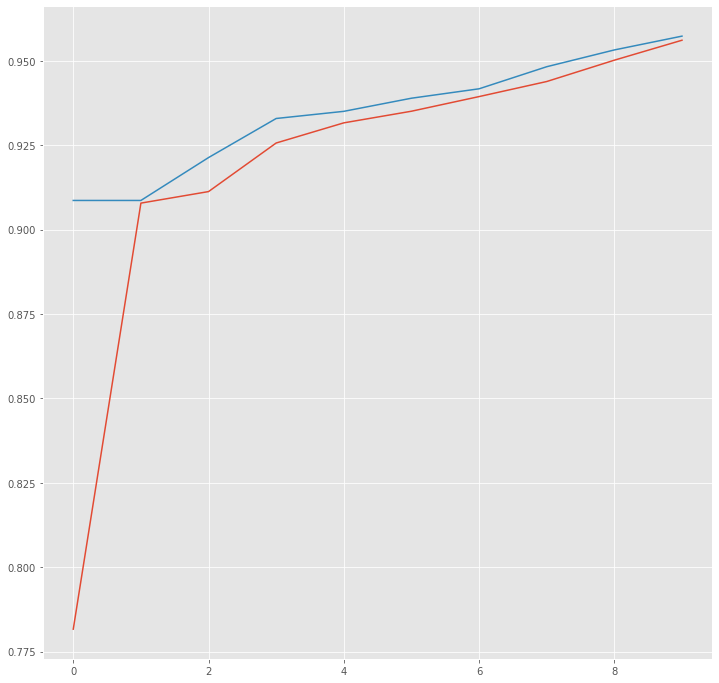

In [33]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12, 12))
plt.plot(hist["crf_viterbi_accuracy"])
plt.plot(hist["val_crf_viterbi_accuracy"])
plt.show()

In [34]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report


In [35]:
test_pred = model.predict(X_te, verbose=1)


452/452 [==============================] - 1s 2ms/step


In [36]:
idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_te)


In [37]:
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))


F1-score: 43.3%


In [38]:
print(classification_report(test_labels, pred_labels))


                                 precision    recall  f1-score   support

             Organism_substance       0.00      0.00      0.00        37
             Cellular_component       0.00      0.00      0.00        64
                           Cell       0.72      0.78      0.75       329
                         Cancer       0.75      0.77      0.76       224
               tissue_structure       0.21      0.44      0.29       124
         Pathological_formation       0.00      0.00      0.00        22
   Immaterial_anatomical_entity       0.00      0.00      0.00        19
                         Tissue       0.00      0.00      0.00        61
                          Organ       0.00      0.00      0.00        60
           Organism_subdivision       0.00      0.00      0.00        17
Developing_anatomical_structure       0.00      0.00      0.00         4
              Anatomical_system       0.00      0.00      0.00         8

                    avg / total       0.44      0

In [39]:
test_sentence = ["The patient suffers from brain and lung cancer."]
test_sentence = [t.split() for t in test_sentence]

In [40]:
test_sentence = test_sentence[0]

In [41]:
x_test_sent = pad_sequences(sequences=[[word2idx.get(w, 0) for w in test_sentence]],
                            padding="post", value=0, maxlen=75)


In [42]:
p = model.predict(np.array([x_test_sent[0]]))
p = np.argmax(p, axis=-1)
print("{:15}||{}".format("Word", "Prediction"))
print(30 * "=")
for w, pred in zip(test_sentence, p[0]):
    print("{:15}: {:5}".format(w, tags[pred]))

Word           ||Prediction
The            : O    
patient        : O    
suffers        : I-Tissue
from           : O    
brain          : B-Cancer
and            : O    
lung           : B-Cancer
cancer.        : I-Tissue
